# Primeiro Modelo

## Imports

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np, h5py, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'O device a ser utilizado será {device}')

O device a ser utilizado será cuda


## Pegando o arquivo HDF5

In [3]:
file = h5py.File('data/dataset.h5', 'r')

In [4]:
## treino
x_train = file['samples_train']
y_train = file['labels_train']
## validação
x_val = file['samples_val']
y_val = file['labels_val']
## teste
x_test = file['samples_test']

## Criando a classe do Dataset

In [5]:
class DigitData(Dataset):
    def __init__(self, x, y=None):
        assert len(x) == len(y), 'x tem que ter mesma dimensão 0 que y'
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i] 

In [6]:
ds_train = DigitData(x_train, y_train)
ds_val = DigitData(x_val, y_val)

### Checando se os dados estão corretos

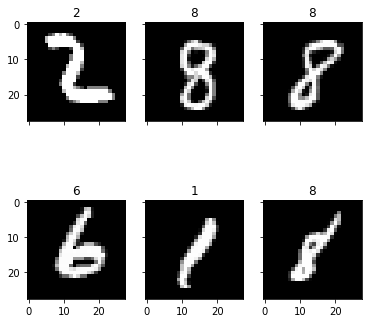

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(6,6))
for i, ax in enumerate(axs.flatten()):
    x, y = ds_val[i]
    ax.set_title(y)
    ax.imshow(x.reshape((28,28)), cmap='gray')

## Criando o modelo

In [22]:
class Model(nn.Module):
    
    def __init__(self, input_size, hidden_nodes, output_size):
        super().__init__()
        self.n, self.c = input_size, output_size
        self.nodes = hidden_nodes if isinstance(hidden_nodes, list) else list(hidden_nodes)
        self.nodes = [self.n] + self.nodes
        
        ## camadas iniciais
        layers = []
        for i in range(len(self.nodes)-1):
            layers += [self.linear_layer(self.nodes[i], self.nodes[i+1])]
        ## ultima camada
        layers += [nn.Linear(self.nodes[-1], self.c)]
        
        self.net = nn.Sequential(*layers)
        
    def linear_layer(self, input_size, output_size):
        return nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.net(x)

In [9]:
model = Model(784, [256, 128, 64, 32], 10)
model.to(device)

Model(
  (net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
    )
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)

## Criando os DataLoaders

In [10]:
bs = 64

In [11]:
dl_train = DataLoader(ds_train, batch_size=bs, shuffle=True, num_workers=0)
dl_val = DataLoader(ds_val, batch_size=bs, num_workers=0, shuffle=True)

## Checando que tudo está funcionando

In [12]:
x, y = next(iter(dl_val))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [13]:
out = model(x.to(device))
out.shape

torch.Size([64, 10])

## Definindo as métricas

In [14]:
def to_numpy(x): return x.cpu().detach().numpy()

In [15]:
def equals(predicted, targets):
    return sum(predicted.long() == targets.long())

In [16]:
def accuracy_and_loss(model, data_loader, loss_fn, iterations=500):
    model.eval()
    loss_tracker, counter, acc, szs = 0, 0, 0., 0
    for x, y in data_loader:
        out = model(x.to(device))
        loss_tracker += loss_fn(out, y.long().to(device))
        acc += to_numpy(equals(out.argmax(1), y.to(device)))
        szs += len(to_numpy(out))
        ## 
        counter += 1
        if counter >= iterations and iterations > 0: break
    return to_numpy(loss_tracker)/counter, acc/szs

## Definindo otimizador e função de custo

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Checando novamente

In [18]:
loss, acc = accuracy_and_loss(model, dl_val, loss_fn)

In [19]:
loss, acc

(3.0366154924223694, 0.092)

## Treinando

In [20]:
# model.load_state_dict(torch.load('models/naive_model.pt'))

In [21]:
loss_train_tracker = []
loss_val_tracker = []
acc_train_tracker = []
acc_val_tracker = []

In [22]:
for ep in range(25):
    model.train()
    
    for x, y in dl_train:
        optimizer.zero_grad()
        out = model(x.to(device))
        loss = loss_fn(out, y.long().to(device))
        loss.backward()        
        optimizer.step()
            
    loss_train, acc_train = accuracy_and_loss(model, dl_train, loss_fn)
    loss_val, acc_val = accuracy_and_loss(model, dl_val, loss_fn)
    
    loss_train_tracker.append(loss_train); acc_train_tracker.append(acc_train)
    loss_val_tracker.append(loss_val); acc_val_tracker.append(acc_val)
    
    print(f'Epoch {ep} Train: loss {loss_train:.5f} acc {acc_train:.5f} Val: loss {loss_val:.5f} acc {acc_val:.5f}')

Epoch 0 Train: loss 0.12756 acc 0.96022 Val: loss 0.16857 acc 0.94066
Epoch 1 Train: loss 0.10128 acc 0.96722 Val: loss 0.16017 acc 0.94502
Epoch 2 Train: loss 0.06124 acc 0.98128 Val: loss 0.12432 acc 0.95352
Epoch 3 Train: loss 0.05657 acc 0.98234 Val: loss 0.11049 acc 0.95886
Epoch 4 Train: loss 0.05148 acc 0.98434 Val: loss 0.12226 acc 0.95451
Epoch 5 Train: loss 0.07501 acc 0.97875 Val: loss 0.16427 acc 0.94897
Epoch 6 Train: loss 0.03974 acc 0.98813 Val: loss 0.12657 acc 0.95767
Epoch 7 Train: loss 0.02464 acc 0.99272 Val: loss 0.10663 acc 0.96044


KeyboardInterrupt: 

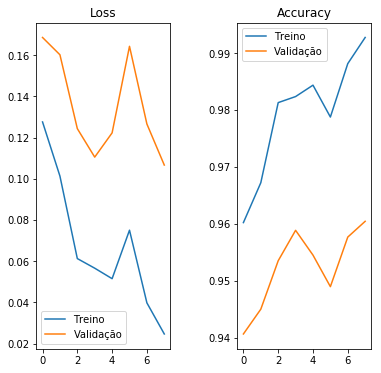

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6,6))
fig.subplots_adjust(wspace=0.5)
## loss
ax1.plot(loss_train_tracker)
ax1.plot(loss_val_tracker)
ax1.set_title('Loss')
ax1.legend(['Treino', 'Validação'])
## accuracy
ax2.plot(acc_train_tracker)
ax2.plot(acc_val_tracker)
ax2.set_title('Accuracy')
ax2.legend(['Treino', 'Validação'])

In [29]:
torch.save(model.state_dict(), 'models/naive_model.pt')

## Estimando o teste

In [59]:
predicts = []
model.eval()
for i in range(0, len(x_test), bs):
    start, end = i, min(i + bs, len(x_test))
    x = torch.tensor(x_test[start:end]).to(device)
    out = model(x)
    predicts += to_numpy(out.argmax(1)).tolist()

## Colocando em um DataFrame

In [65]:
submission = pd.DataFrame(data=predicts, columns=['Label'])
submission.index.name = 'ImageId'
submission.index += 1

In [66]:
submission.head()

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3


## Checando os cinco primeiros

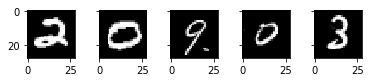

In [8]:
fig, axs = plt.subplots(ncols=5, figsize=(6, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.5)
for i, ax in enumerate(axs):
    ax.imshow(x_test[i].reshape((28,28)), cmap='gray')

## Submetendo no kaggle

In [68]:
submission.to_csv('submissions/naive.csv')

<img src="images/naive_submission.png">